# Draft start of data analysis 

In [1]:
#importing relevant modules and libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
from matplotlib.lines import Line2D
# from sentence_transformers import SentenceTransformer, util

## Microagression Dataset

In [3]:
#READ IN DATA
maData = pd.read_csv("./Datasets/MicroAgressions/selfma_typology.csv", skiprows = 1 ) #skiprows = 2, header = None
maData.drop(maData.columns[0], axis=1, inplace=True)
maData.fillna(0,inplace=True)

#INITIALISE SETS
maData = maData.head(1300)
numRows = maData.shape[0]
maIDs = maData.iloc[:,0]
maText = maData.iloc[:, 1:3]
mainThemesData = maData.iloc[:, -4:]
#mainThemesData = pd.concat([maIDs,mainThemesData],axis=1)
subThemesData = maData.iloc[:, 3:-4]
#subThemesData = pd.concat([maIDs,subThemesData],axis=1)
themesData = maData.iloc[:, 3:]
#subThemesCount = {'Stereotype', 'Second-Class Citizen', 'Objectification', 'Criminal Status', 'Abnormality', 'Alien in Own Land', 'Myth of Meritocracy', 'Denial of Lived Exp', 'Monolith', 'Erasure', 'Ownership', 'Overt Aggression'}
#mainThemesCount = {'attributive', 'institutionalized', 'teaming', 'othering'}


In [4]:
#COMPUTE FREQUENCY AND LENGTH OF TEXT WITHIN OF VARIOUS CLASSES 
#AND STORE IN APPROPIATE DICTIONARIES TO LATER VISUALISE

#total count for number of samples attributed to each theme/class
subThemesCount={}
mainThemesCount={}
#themesCount will count the total num of samples attributed to each subTheme for each of the mainThemes
themesCount = {}
# subThemesCountMultiple > subThemesCount as it takes into account samples where subThemes are attributed to more 
# .. than one mainTheme. Same logic w.r.t mainThemesCountMultiple
subThemesCountMultiple = {}
mainThemesCountMultiple = {}

#quoteChar should have following structure:
# {'someTheme': [[list of char lengths],[list of references/indices to original text/quote]]}

        # {'someTheme': [number of quotes, cummulative sum of quote length, min_length, max_length]}
        # .. same for textChar
quoteChar = {}
textChar = {}

for mainTheme in list(mainThemesData.columns):
    mainThemesCount[mainTheme] = int(mainThemesData[mainTheme].sum())
    themesCount[mainTheme] = {} #initialising themesCount
    mainThemesCountMultiple[mainTheme] = 0 #initialising mainThemesCountMultiple
    quoteChar[mainTheme] = [[],[]]
    textChar[mainTheme] = [[],[]]
    
for subTheme in list(subThemesData.columns):
    subThemesCount[subTheme] = int(subThemesData[subTheme].sum())
    subThemesCountMultiple[subTheme] = 0 #initialising subThemesCountMultiple
    quoteChar[subTheme] = [[],[]]
    textChar[subTheme] = [[],[]]
    
    for mainTheme in list(mainThemesData.columns):
        themesCount[mainTheme][subTheme] = 0 #initialising themesCount

        
for i in range(numRows):
    currSubThemes = [] #list to keep track of all subthemes attributed to current sample
    for subTheme in list(subThemesData.columns):
        if (subThemesData.loc[i][subTheme]==1.0):
            currSubThemes.append(subTheme)
            
    for mainTheme in list(mainThemesData.columns):
        currNum = mainThemesData.loc[i][mainTheme]
        if (currNum==1.0):
            for subTheme in currSubThemes:
                themesCount[mainTheme][subTheme] +=1 
                subThemesCountMultiple[subTheme] +=1
                mainThemesCountMultiple[mainTheme] +=1
    

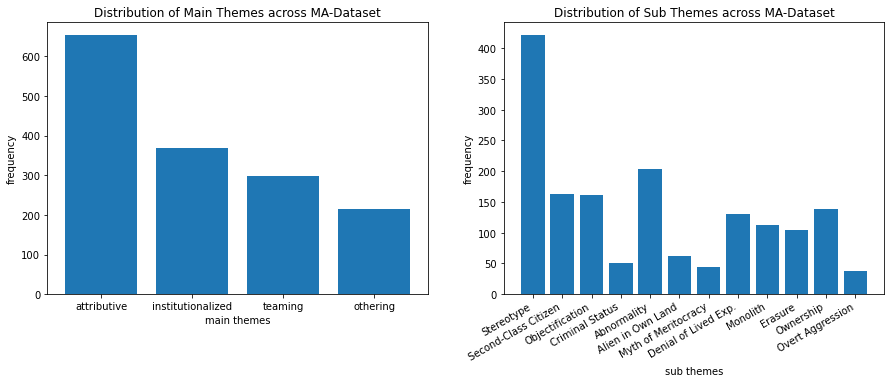

In [5]:
#PLOT TOTAL COUNT OF MAIN THEMES AND SUB THEMES ACROSS WHOLE DATASET

#histogram portraying total counts
plt.figure(figsize=(15,5)) # default 6.4 and 4.8.

plt.subplot(121) 
plt.bar(mainThemesData.columns, list(mainThemesCount.values()))
plt.ylabel('frequency')
plt.xlabel('main themes')
plt.title('Distribution of Main Themes across MA-Dataset')

plt.subplot(122) 
plt.bar(subThemesData.columns, list(subThemesCount.values()))
plt.ylabel('frequency')
plt.xlabel('sub themes')
plt.title('Distribution of Sub Themes across MA-Dataset')
plt.xticks(rotation=30, ha='right')
plt.show()


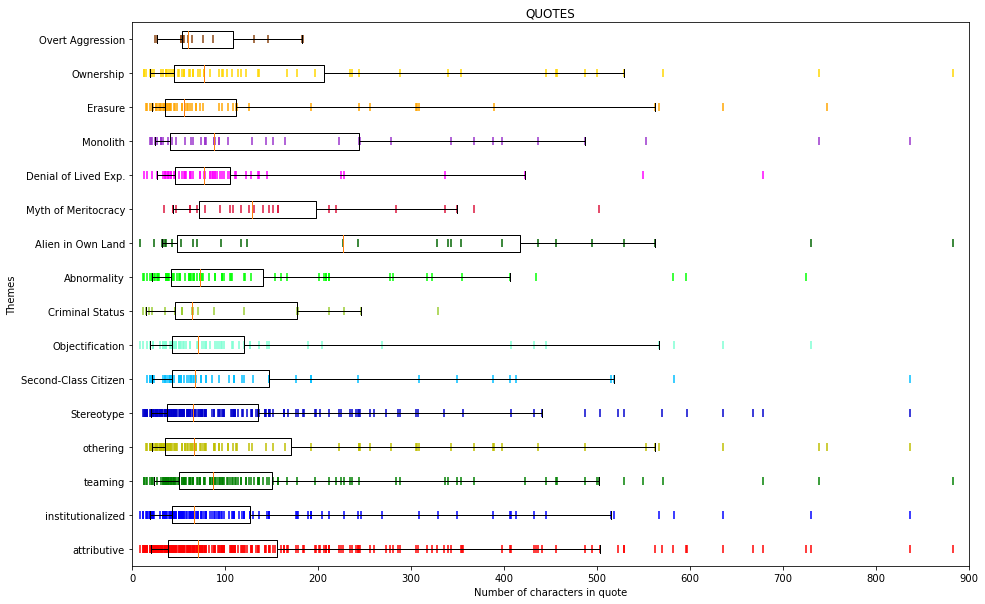

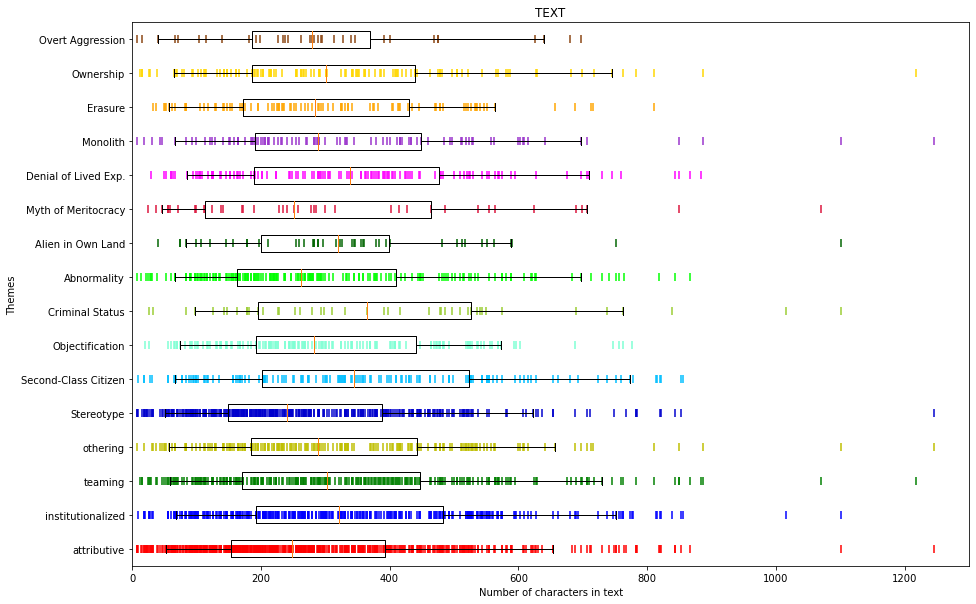

In [6]:
#WANT TO ANALYSE LENGTH OF TEXT ACROSS VARIOUS CLASSES
#Note that the 'Text' column is a decription of the event leading up to the microaggression
# or the context surrounding it
#Note that the 'Quote' column is in most cases a quotation of the micro-aggressive remark
#would make more intuitive sense to analyse Quote column but can take into account text column too in case

# {'someTheme': [[list of char lengths],[list of references/indices to original text/quote]]}

for i in range(numRows):
    currRow = maData.loc[i]
    currThemes = []
    for subTheme in list(subThemesData.columns):
        if (currRow[subTheme]==1.0):
                currThemes.append(subTheme)
    for mainTheme in list(mainThemesData.columns):
        if (currRow[mainTheme]==1.0):
                currThemes.append(mainTheme)
                
    if (currRow["Quote"]!=0):
        for theme in currThemes:
            quoteLength = len(currRow["Quote"])
            quoteChar[theme][0].append(quoteLength)
            quoteChar[theme][1].append(i)
                    
    if (currRow["Text"]!=0):
        for theme in currThemes:
            textLength = len(currRow["Text"])
            textChar[theme][0].append(textLength)
            textChar[theme][1].append(i)

plt.figure(figsize=(15,10)) # default 6.4 and 4.8.

#MAKE BOX PLOT
boxData=[]
boxLabels = list(quoteChar.keys())
for theme in quoteChar:
    boxData.append(np.array(quoteChar[theme][0]))
bpQuote = plt.boxplot(boxData,vert = False, whis=[5, 95], positions=range(0,len(boxLabels)), labels = boxLabels, showfliers=False)


colourInd = 0 
coloursMain = ['r','b','g','y']
colourNames = ["mediumblue","deepskyblue","aquamarine","yellowgreen","lime","darkgreen","crimson","magenta","darkorchid","orange","gold","saddlebrown"]
coloursSub = list(map(lambda x: mcolors.CSS4_COLORS[x], colourNames))
colours = coloursMain + coloursSub
    
#PLOT SCATTER GRAPH
for theme in quoteChar:
    x = np.array(quoteChar[theme][0])
    y = np.full(x.size, theme)
    plt.scatter(x, y, s= 80, marker="|", color=colours[colourInd])
    colourInd += 1
    
plt.xlabel('Number of characters in quote')
plt.ylabel('Themes')
plt.title('QUOTES')
plt.xlim(0,900) #max char num for quotes is > 1200, only 4 outliers with char length > 900
plt.show()


#SAME GRAPH AGAIN BUT FOR 'TEXT' SAMPLES RATHER THAN QUOTES

plt.figure(figsize=(15,10)) # default 6.4 and 4.8.
colourInd = 0

#MAKE BOX PLOT
boxData=[]
boxLabels = list(textChar.keys())
for theme in textChar:
    boxData.append(np.array(textChar[theme][0]))
bpText = plt.boxplot(boxData,vert = False, whis=[5, 95], positions=range(0,len(boxLabels)), labels = boxLabels, showfliers=False)


#PLOT SCATTER GRAPH
for theme in textChar:
    x = np.array(textChar[theme][0])
    y = np.full(x.size, theme)
    plt.scatter(x, y, s= 80, marker="|", color=colours[colourInd])
    colourInd += 1

plt.xlabel('Number of characters in text')
plt.ylabel('Themes')
plt.title('TEXT')
plt.xlim(0,1300) #max char num for quotes is ~= 4000, only 6 outliers with length > 1300
plt.show()


In [7]:
# boxes: the main body of the boxplot showing the quartiles and the median's confidence intervals if enabled.
# medians: horizontal lines at the median of each box.
# whiskers: the vertical lines extending to the most extreme, non-outlier data points.
# caps: the horizontal lines at the ends of the whiskers.
# fliers: points representing data that extend beyond the whiskers (fliers).
# means: points or lines representing the means.

#gets medians for data above
textMed = []
for themeData in bpText['medians']:
    themeMed = themeData.get_xdata()
    textMed.append(int(themeMed[0]))
quoteMed = []
for themeData in bpQuote['medians']:
    themeMed = themeData.get_xdata()
    quoteMed.append(int(themeMed[0]))


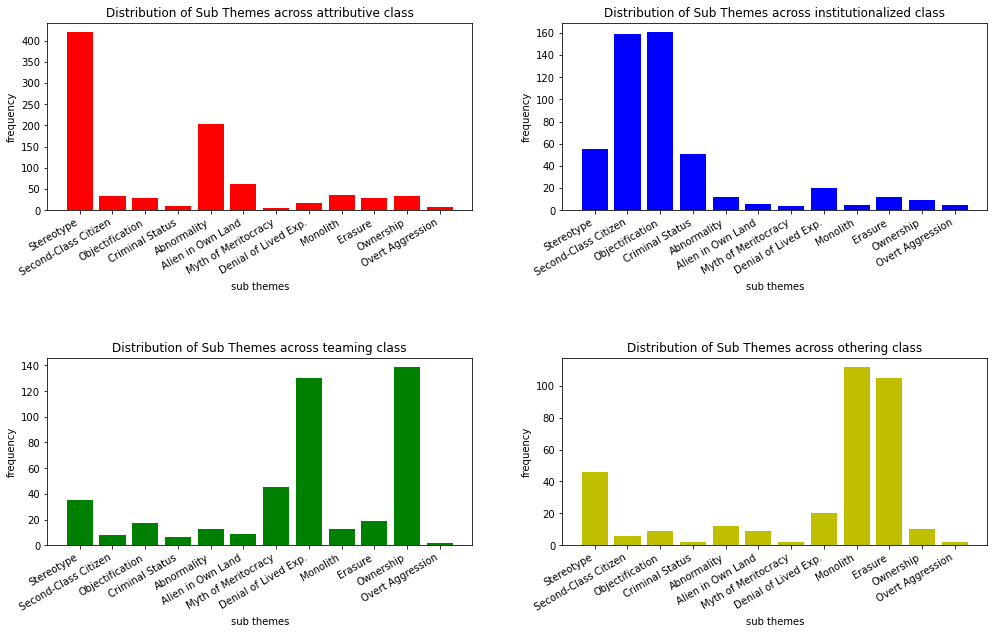

In [8]:
#PLOT TOTAL COUNT OF SUB THEMES IN EACH OF MAIN CLASSES

#various histograms 
plt.figure(figsize=(15,10)) # default 6.4 and 4.8.
colours = ['r','b','g','y']
plotNum = 0
for mainTheme in mainThemesData.columns:
    plt.subplot(221+plotNum)
    x = list(themesCount[mainTheme].keys())
    y = list(themesCount[mainTheme].values())
    plt.bar(x, y, color=colours[plotNum])
    plotNum += 1
    
    plt.ylabel('frequency')
    plt.xlabel('sub themes')
    plt.title(f"Distribution of Sub Themes across {mainTheme} class") 
    plt.xticks(rotation=30, ha='right')

plt.tight_layout(pad=5.0)
plt.show()


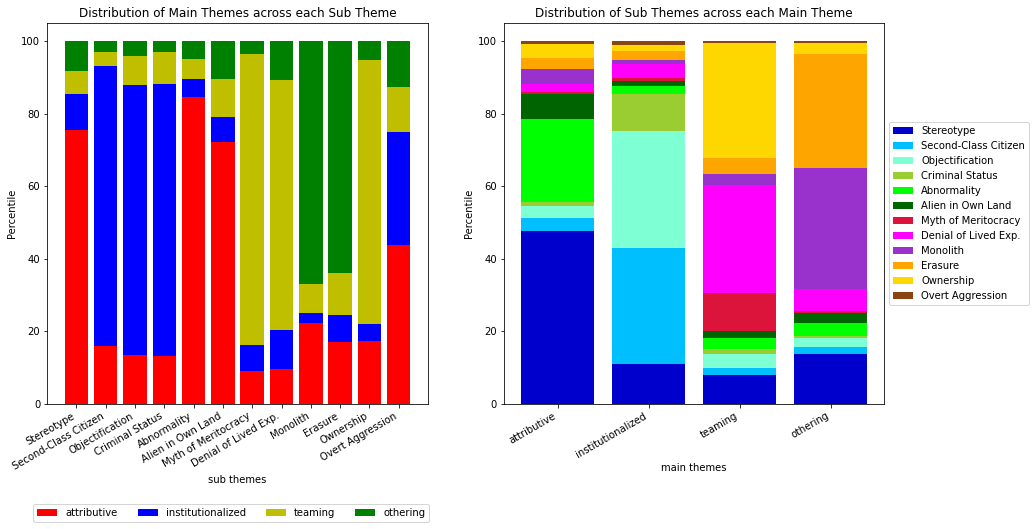

In [9]:
#VISUALISE CONSTITUTION OF MAIN THEMES AND SUB THEMES
#I.E. THE PERCENTAGE OF SUBTHEMES ATTRIBUTED TO TEXT IN A MAIN THEME AND VISA VERSA

#stacked bar charts
plt.figure(figsize=(15,7))
plt.subplot(121)
colourInd = 0
colours = ['r','b','y','g']
yTotal = np.array(list(subThemesCountMultiple.values()))
yPrev= np.zeros(len(subThemesData.columns))
for mainTheme in mainThemesData.columns:
    x = np.array(list(themesCount[mainTheme].keys()))
    y = np.array(list(themesCount[mainTheme].values()))
    y = (y/yTotal)*100
        
    plt.bar(x, y, bottom = yPrev, color=colours[colourInd])
    yPrev += y
    colourInd += 1
    
plt.ylabel('Percentile')
plt.xlabel('sub themes')
plt.title("Distribution of Main Themes across each Sub Theme") 
plt.xticks(rotation=30, ha='right')
#plt.legend(mainThemesData.columns)
plt.legend(mainThemesData.columns,loc='upper left', bbox_to_anchor=(-0.05, -0.25),ncol=4)

#get transpose of themesCount dictionary
themesCountAdj = {}
for subTheme in subThemesData.columns:
    themesCountAdj[subTheme] = {}
    for mainTheme in mainThemesData.columns:
        themesCountAdj[subTheme][mainTheme] = themesCount[mainTheme][subTheme]
    

plt.subplot(122)
colourInd = 0 
#colours = ["r", mcolors.CSS4_COLORS["yellowgreen"], "b", "y", "m", "c","r", "g", "b", "y", "m", "c"]
colourNames = ["mediumblue","deepskyblue","aquamarine","yellowgreen","lime","darkgreen","crimson","magenta","darkorchid","orange","gold","saddlebrown"]
colours = list(map(lambda x: mcolors.CSS4_COLORS[x], colourNames))

yTotal = np.array(list(mainThemesCountMultiple.values()))
yPrev= np.zeros(len(mainThemesData.columns))
for subTheme in subThemesData.columns:
    x = np.array(list(themesCountAdj[subTheme].keys()))
    y = np.array(list(themesCountAdj[subTheme].values()))
    y = (y/yTotal)*100
        
    plt.bar(x, y, bottom = yPrev, color=colours[colourInd])
    yPrev += y
    colourInd += 1
    
plt.ylabel('Percentile')
plt.xlabel('main themes')
plt.title("Distribution of Sub Themes across each Main Theme") 
plt.xticks(rotation=30, ha='right')
plt.legend(subThemesData.columns,loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


In [10]:
#mainThemesData.describe()

In [11]:
#subThemesData.describe()

## Sexism Dataset

In [12]:
#read in data
sexismData = pd.read_csv("./Datasets/Sexism/train_all_tasks.csv") 
sexismData.rename(columns={'rewire_id': 'ID', 'label_sexist': 'isSexist', 'label_category':'main_class','label_vector':'sub_class'}, inplace=True)

#notSexistData.drop(notSexistData.columns[], axis=1, inplace=True)
notSexistData = sexismData[sexismData["isSexist"]=="not sexist"]
sexistData = sexismData[sexismData["isSexist"]=="sexist"]


In [13]:
notSexistData.describe()

,ID,text,isSexist,main_class,sub_class
count,10602,10602,10602,10602,10602
unique,10602,10602,1,1,1
top,sexism2022_english-7358,"Damn, this writing was pretty chaotic",not sexist,none,none
freq,1,1,10602,10602,10602


In [25]:
mainCount = dict(sexistData["main_class"].value_counts() )
mainCount

{'2. derogation': 1590,
 '3. animosity': 1165,
 '4. prejudiced discussions': 333,
 '1. threats, plans to harm and incitement': 310}

In [15]:
subCount = dict(sexistData["sub_class"].value_counts()) 
subCount

{'2.1 descriptive attacks': 717,
 '2.2 aggressive and emotive attacks': 673,
 '3.1 casual use of gendered slurs, profanities, and insults': 637,
 '3.2 immutable gender differences and gender stereotypes': 417,
 '4.2 supporting systemic discrimination against women as a group': 258,
 '1.2 incitement and encouragement of harm': 254,
 '2.3 dehumanising attacks & overt sexual objectification': 200,
 '4.1 supporting mistreatment of individual women': 75,
 '3.3 backhanded gendered compliments': 64,
 '1.1 threats of harm': 56,
 '3.4 condescending explanations or unwelcome advice': 47}

In [16]:
subThemes = [
    ['1.1 threats of harm',
    '1.2 incitement and encouragement of harm'],
    ['2.1 descriptive attacks',
    '2.2 aggressive and emotive attacks',
    '2.3 dehumanising attacks & overt sexual objectification'],
    ['3.1 casual use of gendered slurs, profanities, and insults',
    '3.2 immutable gender differences and gender stereotypes',
    '3.3 backhanded gendered compliments',
    '3.4 condescending explanations or unwelcome advice'],
    ['4.1 supporting mistreatment of individual women',
    '4.2 supporting systemic discrimination against women as a group']]
        
mainThemes = [
    '1. threats, plans to harm and incitement',
    '2. derogation',
    '3. animosity',
    '4. prejudiced discussions']

# systemCount = {}
# for classInd, mainThemeSet in enumerate(subThemes):
#     currMain = mainThemes[classInd]
#     systemCount[currMain] = {}
#     for subTheme in mainThemeSet:
#         systemCount[currMain][subTheme] = subCount[subTheme]
        
        
# systemCount

In [17]:
baseColours = [[0.2,0.2,0,1],[0,0.2,0.2,1],[0.2,0,0.2,1],[0.5,0,0,0.2]]

def getColours(iteration):
    colours = []
    increase = 0.2
    for i in range(4):
        currColour = baseColours[i]
        currColour[i] += increase
        if (i!=3):
            my_mod = ((i+1)%3)
            currColour[my_mod] += increase
        colours.append(tuple(currColour))
    return colours

In [18]:
yMulti = []
yLegend= []
colours = []
isntDone = True

level = 0
while isntDone:
    currYCount = []
    isntDone = False
    currColours = getColours(level)
    
    for i in range(len(mainThemes)): 
        if (level>=len(subThemes[i])):
            currYCount.append(0)
        else:
            currY = subThemes[i][level]
            currYCount.append(subCount[currY])
            yLegend.append(currY)
            colours.append(currColours[i])
            isntDone = True
        
    if (isntDone):
        yMulti.append(currYCount)
        level +=1 
    
colourLegend = list(map(lambda colour: Line2D([0], [0], color=colour, lw=4) ,colours))

themeColDict = {}
for i in range(len(yLegend)):
    currSubTheme = yLegend[i]
    themeColDict[currSubTheme] = colours[i]
    

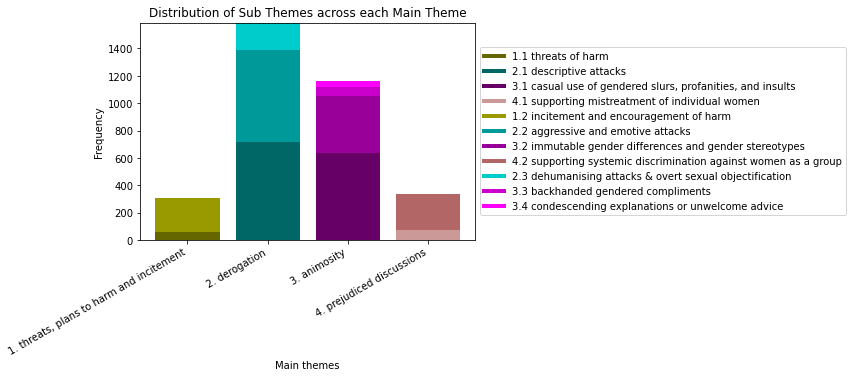

In [19]:
baseColours = [[0.2,0.2,0,1],[0,0.2,0.2,1],[0.2,0,0.2,1],[0.5,0,0,0.2]]
yPrev= np.zeros(len(mainThemes))
for iteration, yList in enumerate(yMulti):
    x = np.array(mainThemes)
    y = np.array(yList)
    colours = getColours(iteration)
    plt.bar(x, y, bottom = yPrev, color=colours,label='mainClass')
    yPrev += y
    colourInd += 1
    plt.legend()
    
plt.ylabel('Frequency')
plt.xlabel('Main themes')
plt.title("Distribution of Sub Themes across each Main Theme") 
plt.xticks(rotation=30, ha='right')
plt.legend(colourLegend, yLegend,loc='center left', bbox_to_anchor=(1, 0.5))
# plt.legend(subThemesData.columns,loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

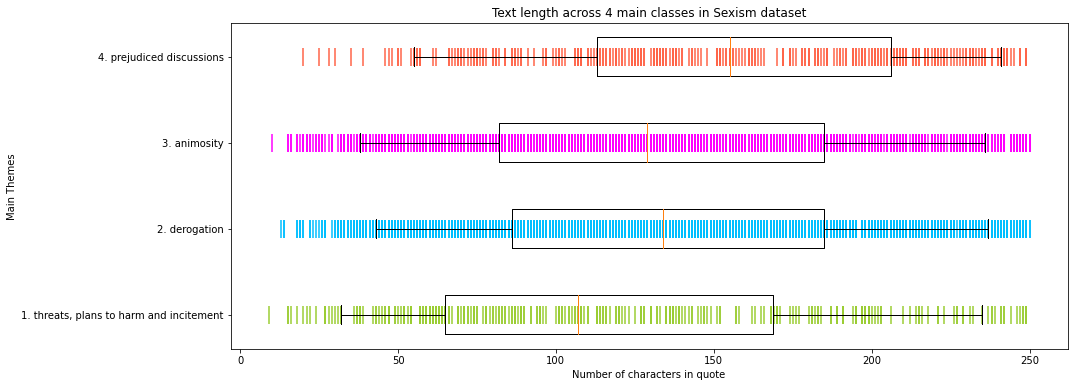

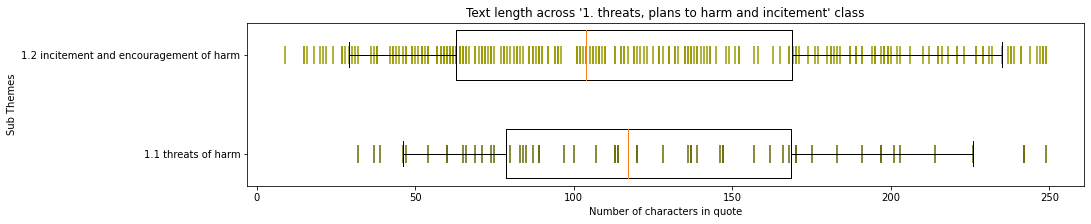

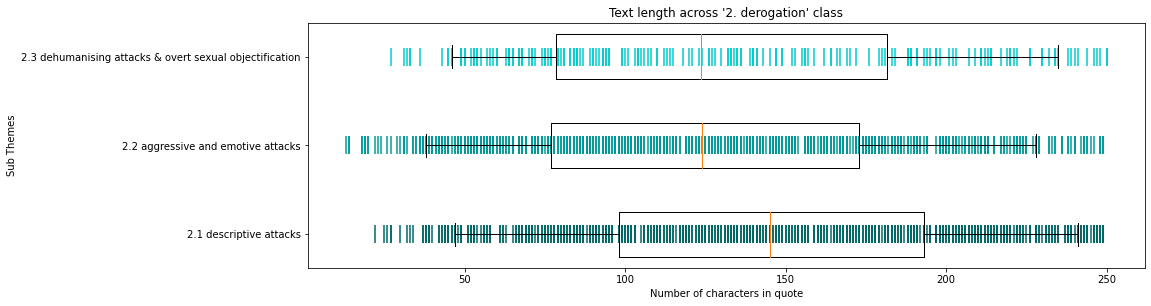

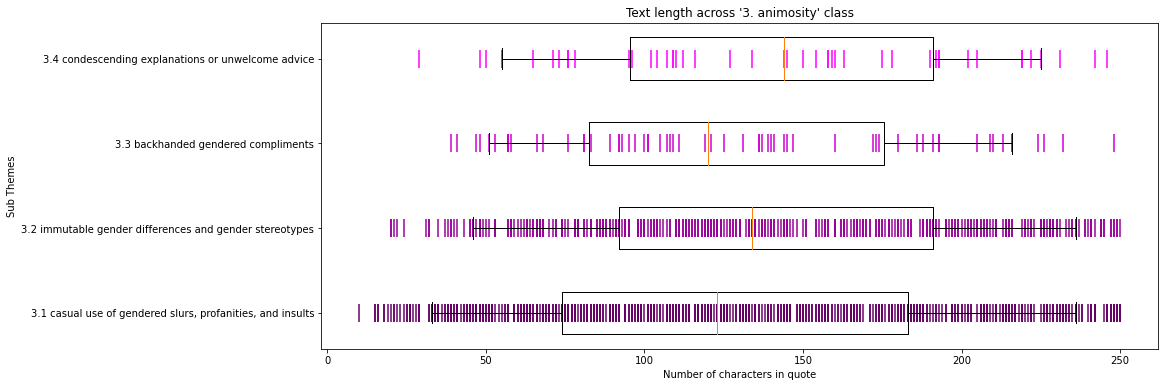

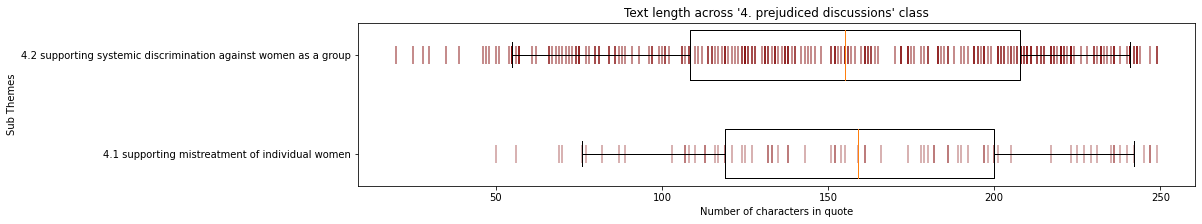

In [20]:
#WANT TO ANALYSE LENGTH OF TEXT ACROSS VARIOUS CLASSES

# {'someTheme': [[list of char lengths],[list of references/indices to original text/quote]]}

textChar = {}
numRows = sexistData.shape[0]
for mainSet in subThemes:
    for theme in mainSet:
        textChar[theme] = [[],[]]
for theme in mainThemes:
    textChar[theme] = [[],[]]
    
for i in range(numRows):
    currRow = sexistData.iloc[i]
    currThemes = []
    currThemes.append(currRow["sub_class"])
    currThemes.append(currRow["main_class"])
                
    for theme in currThemes:
        textLength = len(currRow["text"])
        textChar[theme][0].append(textLength)
        textChar[theme][1].append(i)

#VISUALISE DATA
        
plt.figure(figsize=(15,6)) # default 6.4 and 4.8.

#MAIN THEMES FIRST..

#MAKE BOX PLOT themeColDict
boxData=[]
boxLabels = mainThemes
for theme in mainThemes:
    boxData.append(np.array(textChar[theme][0]))
bpTextMain = plt.boxplot(boxData,vert = False, whis=[5, 95], positions=range(0,len(boxLabels)), labels = boxLabels, showfliers=False)

colourInd = 0 
colourNames = ["yellowgreen", "deepskyblue", "magenta", "tomato"]
colours = list(map(lambda x: mcolors.CSS4_COLORS[x], colourNames)) 

#PLOT SCATTER GRAPH
for theme in mainThemes:
    x = np.array(textChar[theme][0])
    y = np.full(x.size, theme)
    plt.scatter(x, y, s= 320, marker="|", color=colours[colourInd])
    colourInd += 1
    
plt.xlabel('Number of characters in quote')
plt.ylabel('Main Themes')
plt.title('Text length across 4 main classes in Sexism dataset')
#plt.xlim(0,900) #max char num for quotes is > 1200, only 4 outliers with char length > 900
plt.show()


# #NOW FOR SUB THEMES...

# default 6.4 and 4.8.
figureNum = 411
colourInd = 0

for i, mainSet in enumerate(subThemes): 
    height = len(mainSet)*1.5
    plt.figure(figsize=(15,height))
#     plt.subplot(figureNum)
    
    #MAKE BOX PLOT
    boxData=[]
    boxLabels = mainSet
    for theme in mainSet:
        boxData.append(np.array(textChar[theme][0]))
    bpText = plt.boxplot(boxData,vert = False, whis=[5, 95], positions=range(0,len(boxLabels)), widths=0.5, labels = boxLabels, showfliers=False)

#themeColDict

    #PLOT SCATTER GRAPH
    for theme in mainSet:
        x = np.array(textChar[theme][0])
        y = np.full(x.size, theme)
        plt.scatter(x, y, s= 320, marker="|", color=themeColDict[theme])

    plt.xlabel('Number of characters in quote')
    plt.ylabel('Sub Themes')
    plt.title(f"Text length across '{mainThemes[i]}' class")
    #plt.xlim(0,900) #max char num for quotes is > 1200, only 4 outliers with char length > 900
    plt.show()


## Homophobia and Transphobia Dataset

In [21]:
#read in data 
queerData = pd.read_csv("./Datasets/QueerYouTubeComments/English_train.csv",skiprows = 1) 
queerData.drop(queerData.columns[2:], axis=1, inplace=True)
queerData.rename(columns={'text            ': 'text'},inplace=True)
notHateData = queerData[queerData["category"]=="Non-anti-LGBT+ content"]
hateData = queerData[queerData["category"]!="Non-anti-LGBT+ content"]

In [22]:
generalCount = dict(queerData["category"].value_counts() )
generalCount

{'Non-anti-LGBT+ content': 3001, 'Homophobic': 157, 'Transphobic': 6}

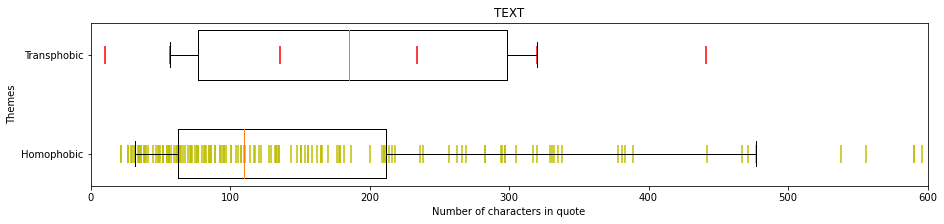

In [23]:
#WANT TO ANALYSE LENGTH OF TEXT ACROSS HOMOPHOBIC AND TRANSPHOBIC CLASSES
# {'someTheme': [[list of char lengths],[list of references/indices to original text/quote]]}

themes = ['Homophobic','Transphobic']
textChar = {}
for theme in themes:
    textChar[theme] = [[],[]]

numRows = hateData.shape[0]
for i in range(numRows):
    currRow = hateData.iloc[i]
    currTheme = currRow["category"] 
    
    textLength = len(currRow["text"])
    textChar[currTheme][0].append(textLength)
    textChar[currTheme][1].append(i)
                    

plt.figure(figsize=(15,3)) # default 6.4 and 4.8.

#MAKE BOX PLOT
boxData=[]
boxLabels = list(textChar.keys())
for theme in textChar:
    boxData.append(np.array(textChar[theme][0]))
bpQuote = plt.boxplot(boxData,vert = False, whis=[5, 95], positions=range(0,len(boxLabels)), widths=0.5, labels = boxLabels, showfliers=False)


colourInd = 0 
colours = ['y','r']
    
#PLOT SCATTER GRAPH
for theme in textChar:
    x = np.array(textChar[theme][0])
    y = np.full(x.size, theme)
    plt.scatter(x, y, s= 320, marker="|", color=colours[colourInd])
    colourInd += 1
    
plt.xlabel('Number of characters in quote')
plt.ylabel('Themes')
plt.title('TEXT')
plt.xlim(0,600) #max char num for quotes is ~= 1000, only 3 outliers with char length > 600
plt.show()
